In [39]:
import cv2
from evaluation_utils import *
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
from random import shuffle

In [40]:
test_files = read_text_lines( "%s/%s" % ('filenames','eigen_test_files.txt') )
gt_files, gt_calib, im_sizes, im_files, cams = read_file_data(test_files, '/data/gengshay/KITTI/')

0 files missing


In [41]:
pred_disp_path = '/scratch/gengshay/tmp/sup-clf-100-depth/disparities.npy'
min_depth = 1e-3
max_depth = 80
nbins=100

In [44]:
bins = np.logspace(np.log(min_depth),np.log(max_depth),num=nbins,base=np.e)

In [46]:
num_samples = len(im_files)
pred_disparities = np.load(pred_disp_path)
gt_depths = []
pred_depths = []
for t_id in range(num_samples):
    camera_id = cams[t_id]  # 2 is left, 3 is right
    depth = generate_depth_map(gt_calib[t_id], gt_files[t_id], im_sizes[t_id], camera_id, False, True)
    # depth = generate_depth_map(gt_calib[t_id], gt_files[t_id], im_sizes[t_id], camera_id, False, True)
    # depth = depth[1]
    gt_depths.append(depth.astype(np.float32))
    #pred_disparities[t_id] =  (np.exp(bins[(pred_disparities[t_id]).astype(np.int32)]) + np.exp(bins[np.clip((pred_disparities[t_id]).astype(np.int32)+1, 0,99)])) /2
    
    disp_pred = cv2.resize(pred_disparities[t_id], (im_sizes[t_id][1], im_sizes[t_id][0]), interpolation=cv2.INTER_LINEAR)
    # disp_pred = disp_pred * disp_pred.shape[1]
    if t_id % 100 == 0:
        print t_id
    
    # need to convert from disparity to depth
    #focal_length, baseline = get_focal_length_baseline(gt_calib[t_id], camera_id)
    #depth_pred = (baseline * focal_length) / disp_pred
    depth_pred = disp_pred.astype(np.int32)
    
    depth_pred =( bins[depth_pred]+bins[np.clip(depth_pred+1, 0,nbins-1)])/2
    # depth_pred[np.isinf(depth_pred)] = 0
    pred_depths.append(depth_pred)

0
100
200
300
400
500
600


In [47]:
rms     = np.zeros(num_samples, np.float32)
log_rms = np.zeros(num_samples, np.float32)
abs_rel = np.zeros(num_samples, np.float32)
sq_rel  = np.zeros(num_samples, np.float32)
d1_all  = np.zeros(num_samples, np.float32)
a1      = np.zeros(num_samples, np.float32)
a2      = np.zeros(num_samples, np.float32)
a3      = np.zeros(num_samples, np.float32)
abs_rel_a = []
sq_rel_a = []
a_a = []
abs_a = []
sq_a = []
log_sq_a = []

for i in range(num_samples):
    gt_depth = gt_depths[i]
    pred_depth = pred_depths[i]

    pred_depth[pred_depth < min_depth] = min_depth
    pred_depth[pred_depth > max_depth] = max_depth
    
    mask = np.logical_and(gt_depth > min_depth, gt_depth < max_depth)

    gt_height, gt_width = gt_depth.shape

    crop = np.array([0.40810811 * gt_height,  0.99189189 * gt_height,   
                     0.03594771 * gt_width,   0.96405229 * gt_width]).astype(np.int32)

    crop_mask = np.zeros(mask.shape)
    crop_mask[crop[0]:crop[1],crop[2]:crop[3]] = 1
    mask = np.logical_and(mask, crop_mask)
    abs_rel[i], sq_rel[i], rms[i], log_rms[i], a1[i], a2[i], a3[i] = compute_errors(gt_depth[mask], pred_depth[mask])
    
    abs_rel_a.append( np.abs(gt_depth[mask] - pred_depth[mask])/ gt_depth[mask])
    abs_a.append( np.abs(gt_depth[mask] - pred_depth[mask]))
    sq_rel_a.append(np.square(gt_depth[mask] - pred_depth[mask])/ gt_depth[mask])
    sq_a.append(np.square(gt_depth[mask] - pred_depth[mask]))
    log_sq_a.append(np.square(np.log(gt_depth[mask]) - np.log(pred_depth[mask])))
    a_a.append(np.max([gt_depth[mask] / pred_depth[mask],pred_depth[mask] / gt_depth[mask]],0))

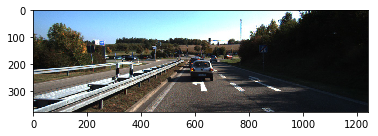

In [48]:
im = plt.imread(im_files[-1])
plt.imshow(im)

In [49]:
pred_depths[-1]

array([[  9.7176578 ,  15.33438093,  27.12046022, ...,  15.33438093,
         12.20713998,  12.20713998],
       [ 10.89150169,  13.68170071,  17.18669655, ...,  13.68170071,
         10.89150169,   9.7176578 ],
       [  9.7176578 ,   9.7176578 ,   9.7176578 , ...,  12.20713998,
          9.7176578 ,   8.67032626],
       ..., 
       [  6.1582449 ,   5.4945331 ,   4.9023536 , ...,  10.89150169,
          7.73587206,   6.1582449 ],
       [ 10.89150169,   9.7176578 ,   7.73587206, ...,  10.89150169,
          9.7176578 ,   7.73587206],
       [ 24.19752201,  17.18669655,  12.20713998, ...,   9.7176578 ,
         10.89150169,  10.89150169]])

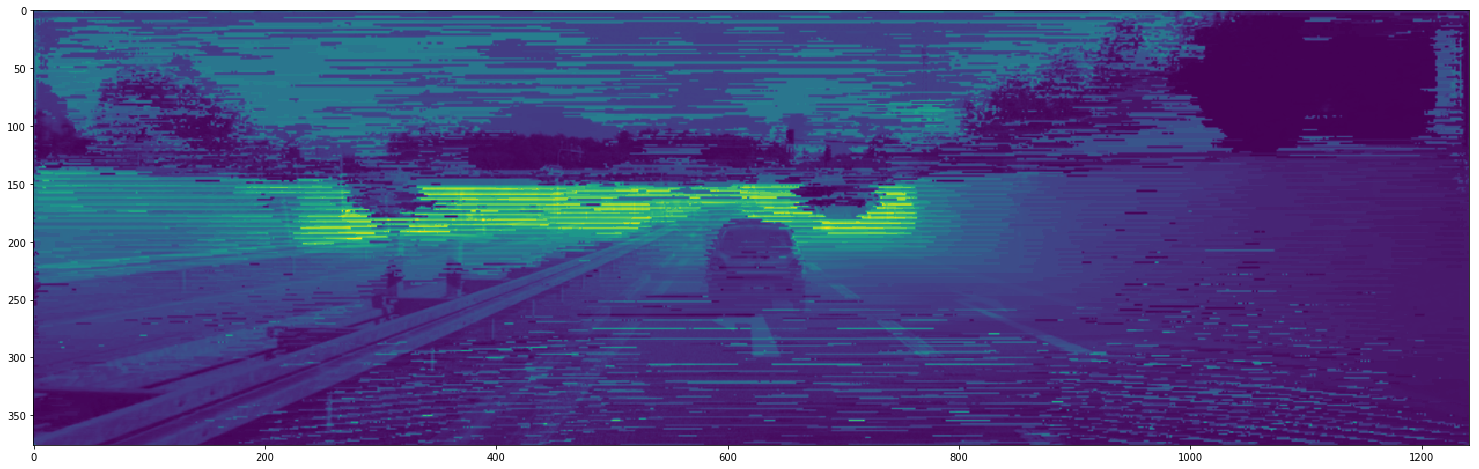

In [50]:
im = cv2.imread(im_files[-1])
mixed = cv2.addWeighted(im[:,:,0].astype(np.float32),0.05,pred_depths[-1].astype(np.float32),1,0)
plt.figure(figsize=(30,8))
plt.imshow(mixed)

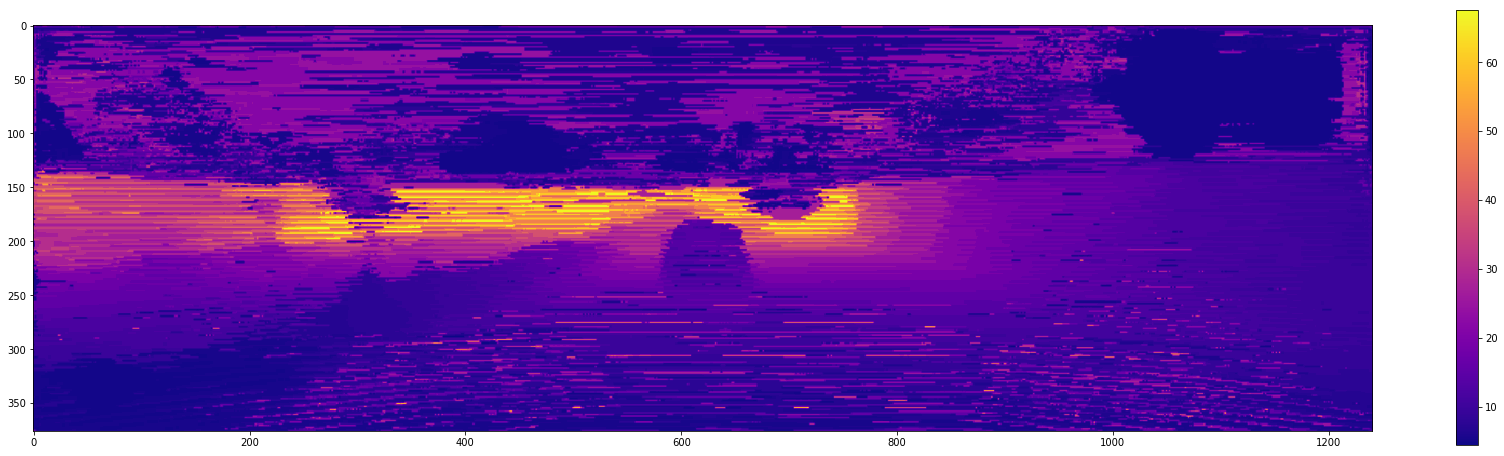

In [51]:
crop = np.array([0.40810811 * gt_height,  0.99189189 * gt_height,   
                     0.03594771 * gt_width,   0.96405229 * gt_width]).astype(np.int32)

crop_mask = np.zeros(mask.shape)
crop_mask[crop[0]:crop[1],crop[2]:crop[3]] = 1
im = pred_depths[-1]
#im = abs(pred_depths[-1] - gt_depths[-1])
#im[~crop_mask.astype(int)] = 0
#im[gt_depths[-1]==0] = 0
plt.figure(figsize=(30,8))
plt.imshow(im,cmap='plasma')
#plt.imshow(gt_depths[-1])
plt.colorbar()

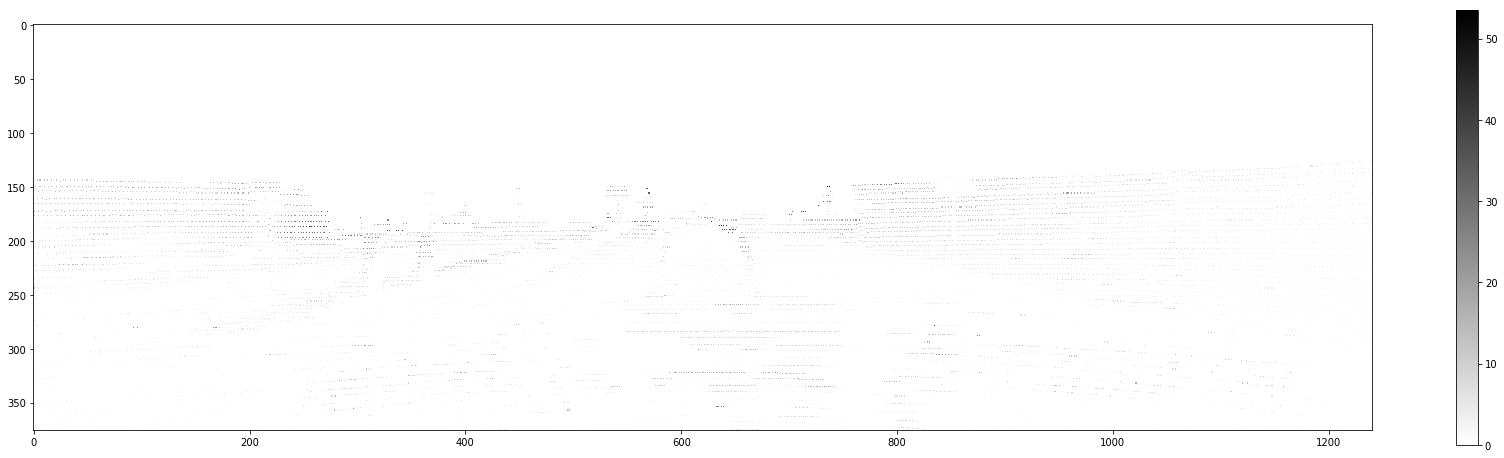

In [52]:
im = abs(pred_depths[-1] - gt_depths[-1])
im[gt_depths[-1]==0] = 0
plt.figure(figsize=(30,8))
plt.imshow(im,cmap='gray_r')
plt.colorbar()

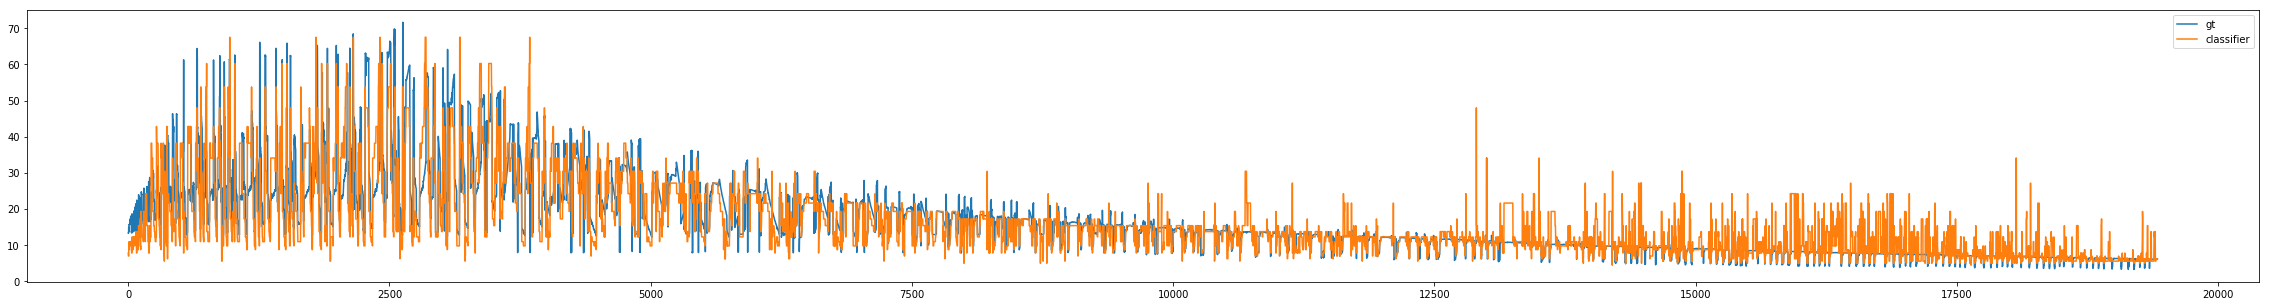

In [53]:
plt.figure(figsize=(40,5))
plt.plot(gt_depth[im>0],label='gt')
plt.plot(pred_depth[im>0],label='classifier')
plt.legend()

In [56]:
print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('abs_rel', 'sq_rel', 'rms', 'log_rms', 'd1_all', 'a1', 'a2', 'a3'))
print("{:10.4f}, {:10.4f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}".format(abs_rel.mean(), sq_rel.mean(), rms.mean(), log_rms.mean(), d1_all.mean(), a1.mean(), a2.mean(), a3.mean()))

   abs_rel,     sq_rel,        rms,    log_rms,     d1_all,         a1,         a2,         a3
    0.2412,     2.3898,      6.396,      0.319,      0.000,      0.714,      0.870,      0.935


In [57]:
def show_error(data,r,t):
    fig = plt.figure(figsize = (20,5))
    plt.hist(np.concatenate(data).ravel(),bins=1000,range=r);
    plt.axvline(x=np.mean(np.concatenate(data).ravel()), color='r');
    plt.title(t);

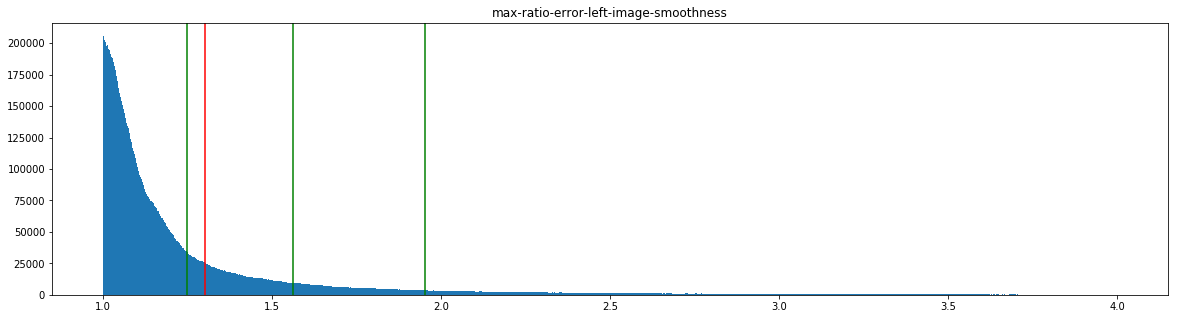

In [58]:
show_error(a_a,(1,4),'max-ratio-error-left-image-smoothness')
plt.axvline(x=1.25, color='g');plt.axvline(x=1.5625, color='g');plt.axvline(x=1.953125, color='g');

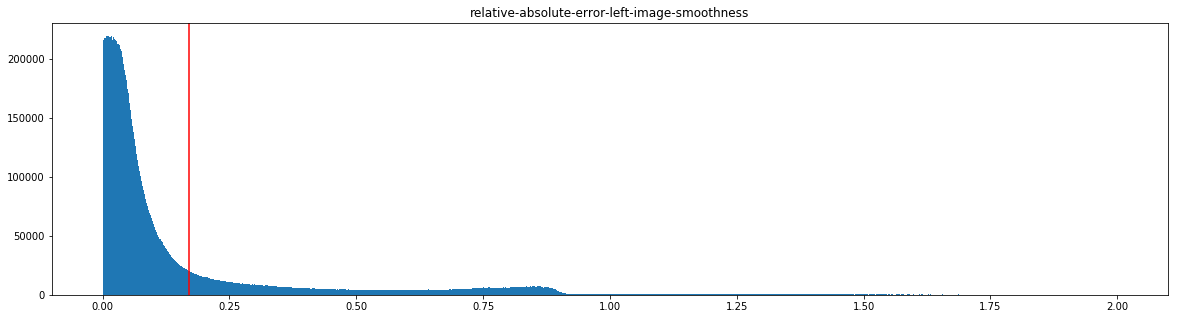

In [65]:
show_error(abs_rel_a,(0,2),'relative-absolute-error-left-image-smoothness')

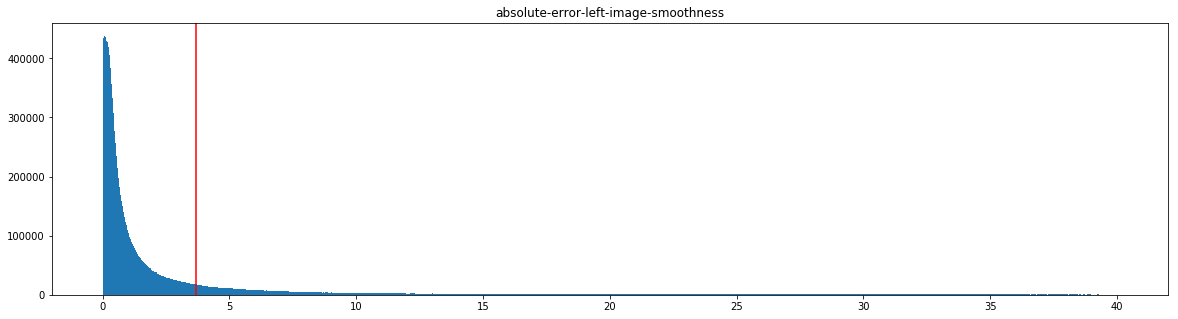

In [66]:
show_error(abs_a,(0,40),'absolute-error-left-image-smoothness')

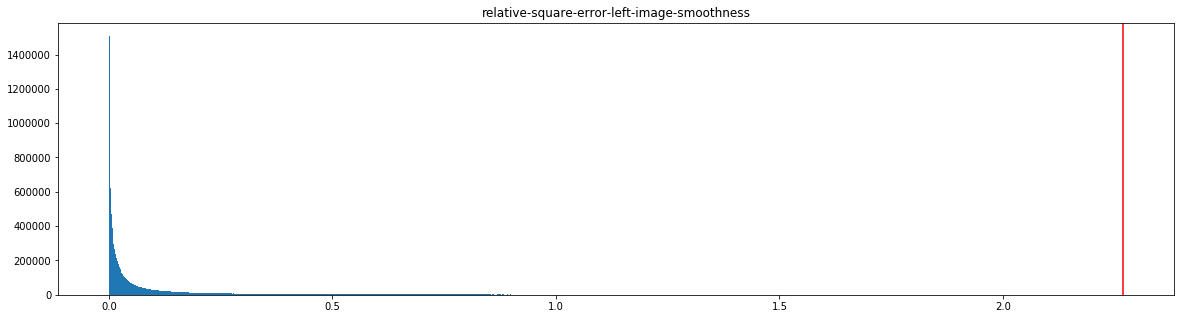

In [58]:
show_error(sq_rel_a,(0,2),'relative-square-error-left-image-smoothness')

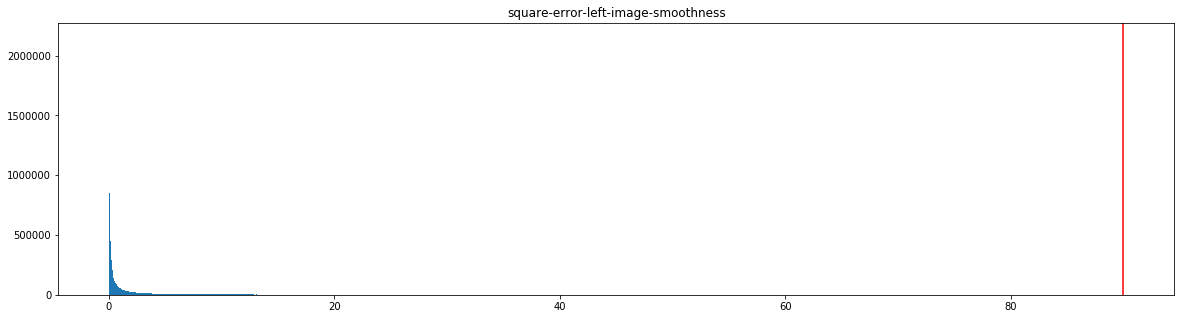

In [59]:
show_error(sq_a,(0,40),'square-error-left-image-smoothness')

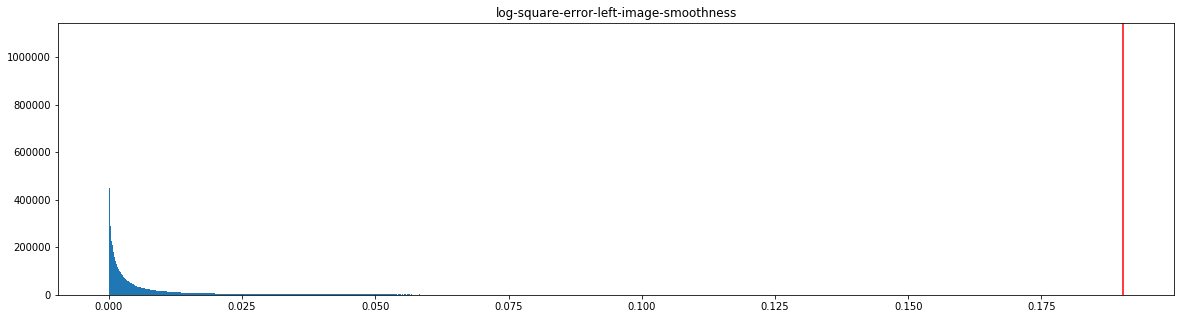

In [60]:
show_error(log_sq_a,(0,0.1),'log-square-error-left-image-smoothness')